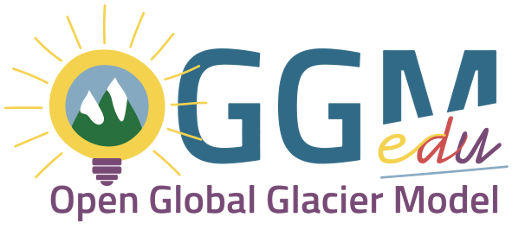

# Influence of ice flow parameters on glacier size

Goals of this notebook:

- The student will be able to implement Glen's creep parameter and basal sliding (sliding parameter) in OGGM.
- The student will be able to explain the influences of the two parameters on glacier shape.

The motion of glaciers is determined by two main processes: One is internal deformation of ice due to gravity and the other is basal sliding. These processes can be described by parameters. In this notebook we will examine their influence on glaciers.

First, we have to import all needed modules:

In [1]:
# The commands below are just importing the necessary modules and functions
# Plot defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)  # Default plot size

# Scientific packages
import numpy as np

# Constants
from oggm import cfg
cfg.initialize()
# OGGM models
from oggm.core.massbalance import LinearMassBalance
from oggm.core.flowline import FluxBasedModel, RectangularBedFlowline, TrapezoidalBedFlowline, ParabolicBedFlowline

# There are several solvers in OGGM core. We use the default one for this experiment
from functools import partial
FlowlineModel = partial(FluxBasedModel, min_dt=0, cfl_number=0.01)

# OGGM Edu helper functions
import oggm_edu as edu

2019-05-18 12:10:06: oggm.cfg: Using configuration file: C:\Program Files\Miniconda3\envs\oggm_env\lib\site-packages\oggm\params.cfg


## Glen's creep parameter

We start with the internal deformation which results in creeping of a glacier. To describe it we use  Glens's creep parameter. The default in OGGM is to set Glen's creep parameter `A` to the "standard value" defined by Cuffey and Paterson[¹](#References):

In [2]:
# Default in OGGM
A = cfg.PARAMS['glen_a']
print(A)

2.4e-24


The parameter relates shear stress to the rate of deformation and is assumed to be constant. It depends on crystal size, fabric, concentration and type of impurities, as well as on ice temperature[²](#References)
(you can find a more detailed description of it [here](http://www.antarcticglaciers.org/modern-glaciers/glacier-flow-2/glacier-flow-ii-stress-and-strain/)). In the following we will change it and see what happens.

Therefore we have to define the bedrock and a grid. (We do similiar steps like in [flowline_model](http://edu.oggm.org/en/latest/notebooks_flowline_intro.html#glacier-flowline-modelling) to generate a set-up for our experiment.)

In [3]:
# This is the bed rock, linearily decreasing from 3400 m altitude to 1400 m, in 200 steps
nx = 200
bed_h = np.linspace(3400, 1400, nx)
# At the beginning, there is no glacier so our glacier surface is at the bed altitude
surface_h = bed_h
# Let's set the model grid spacing to 100 m 
map_dx = 100
# Calculate the corresponding distance along the glacier (from the top)
distance_along_glacier = np.linspace(0, nx, nx) * 0.1 # in km 

# The units of widths is in "grid points", i.e. 3 grid points = 300 m in our case
widths = np.zeros(nx) + 3.
# Define our bed
init_flowline = RectangularBedFlowline(surface_h=surface_h, bed_h=bed_h, widths=widths, map_dx=map_dx)

Define the equilibrium line altitude (ELA):

In [4]:
# ELA at 3000m a.s.l., gradient 4 mm m-1
mb_model = LinearMassBalance(3000, grad=4)

Now we can calculate the evolution of the glacier with the default parameter:

In [5]:
# Define the time span for the model (you can change the number of years if you want)
years = 600
# and Glen's parameter A
A = cfg.PARAMS['glen_a']

In [6]:
# Initialize the model with the following function and save the output as simple_glacier_h
model = edu.init_model(init_flowline, mb_model, years, A, 0)
simple_glacier_h = model.fls[-1].surface_h

Let's make Glen's parameter 10 times smaller and 10 times larger:

In [7]:
# Glen's parameter A
A_small = cfg.PARAMS['glen_a'] / 10
A_large = cfg.PARAMS['glen_a'] * 10

In [8]:
# Reinitialize the model with the new parameter and save the output as stiffer_glacier_h
model = edu.init_model(init_flowline, mb_model, years, A_small)
stiffer_glacier_h = model.fls[-1].surface_h
# And again (save the output as softer_glacier_h)
model = edu.init_model(init_flowline, mb_model, years, A_large)
softer_glacier_h = model.fls[-1].surface_h

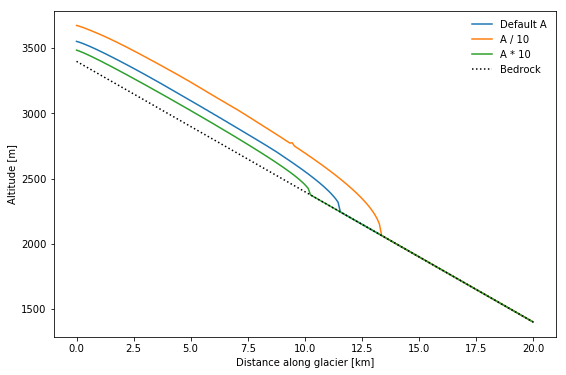

In [9]:
# Plot the results
plt.figure(figsize=(9,6))
plt.plot(distance_along_glacier, simple_glacier_h, label='Default A')
plt.plot(distance_along_glacier, stiffer_glacier_h, label='A / 10')
plt.plot(distance_along_glacier, softer_glacier_h, label='A * 10')
# Add the bedrock and lables
edu.plot_xz_bed(distance_along_glacier, bed_h)

In [10]:
# What do the three graphs show you?
# ...

Maybe you see irregularities visible for the orange line (A/10) at around 3-4 km? These can occur due to numerical inaccuracies.

## Sliding  parameter

Basal sliding occurs when there is a water film between the ice and the ground. In his [seminal paper](https://www.igsoc.org/annals/24/igs_annals_vol24_year1997_pg382-389.pdf), Hans Oerlemans uses a so-called "sliding parameter" (here: fs), representing basal sliding. In OGGM this parameter is set to 0 per default, but it can be modified:

In [11]:
# Sliding parameter
fs = 5.7e-20

In [12]:
# Define the time span for the glacier development:
years = 1500

In [13]:
# Reinitialize the model with the new parameter and save the output as sliding_glacier_h
model = edu.init_model(init_flowline, mb_model, years, A, fs)
sliding_glacier_h = model.fls[-1].surface_h

# We calculate again the simple glacier to compare it
model = edu.init_model(init_flowline, mb_model, years, A, 0)
simple_glacier_h = model.fls[-1].surface_h

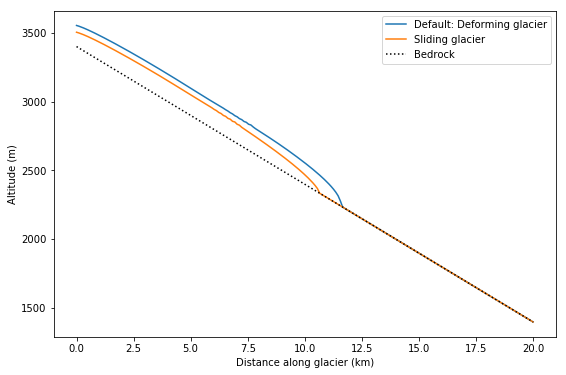

In [14]:
# Plot final result
plt.figure(figsize=(9,6))
plt.plot(distance_along_glacier, simple_glacier_h, label='Default: Deforming glacier')
plt.plot(distance_along_glacier, sliding_glacier_h, label='Sliding glacier')
# Add the bedrock:
plt.plot(distance_along_glacier, init_flowline.bed_h, color='k', label='Bedrock', linestyle=':')
plt.xlabel('Distance along glacier (km)')
plt.ylabel('Altitude (m)')
plt.legend(loc='best');

 If you want to learn more about the processes of glacier flow, I recommend to go through these two pages: 
- [Deformation and sliding](http://www.antarcticglaciers.org/glacier-processes/glacier-flow-2/glacier-flow/)
- [Stress and strain](http://www.antarcticglaciers.org/glacier-processes/glacier-flow-2/glacier-flow-ii-stress-and-strain/)

In the [documentation](https://docs.oggm.org/en/latest/ice-dynamics.html?highlight=oerleman#ice-flow) of OGGM you find also information about the theory of the ice flow parameters and the application.

## References

¹ Cuffey, K., and W. S. B. Paterson (2010). The Physics of Glaciers, Butterworth‐Heinemann, Oxford, U.K.

² Oerlemans, J. (2001). *Glaciers and climate change.* CRC Press. (p. 59)

## What's next?
[Back to table of contents](welcome.ipynb) or [notebook: Glacier surging experiments](surging_experiment.ipynb)